<a href="https://colab.research.google.com/github/SarthakGarg13/OTOMYCOSIS/blob/master/EfficientNet_Otology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import keras
import time
import random
import glob
from keras.applications.xception import Xception
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.inception_v3 import InceptionV3
from keras import optimizers, regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.preprocessing import image
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from keras.models import load_model
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


Using TensorFlow backend.


In [2]:
from keras.preprocessing.image import ImageDataGenerator

image_size = 224
data_generator = ImageDataGenerator()

# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have NUM_CLASSES sub-folders
train_generator = data_generator.flow_from_directory(
        '/content/drive/My Drive/ColabNotebooks/TM imagesCNN',
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        '/content/drive/My Drive/ColabNotebooks/test',
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical') 


Found 238 images belonging to 6 classes.
Found 238 images belonging to 6 classes.


In [3]:
!pip install efficientnet
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
import efficientnet.tfkeras as efn

In [0]:
#Still not talking about our train/test data or any pre-processing.

model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(efn.EfficientNetB5(include_top = True, pooling = 'max', weights = 'imagenet')), Dropout(0.25)


# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(100, activation = 'relu',kernel_regularizer=regularizers.l2(0.01))), Dropout(0.1)
model.add(Dense(25, activation = 'softmax',kernel_regularizer=regularizers.l2(0.01))), Dropout(0.1)
model.add(Dense(6, activation = 'softmax',kernel_regularizer=regularizers.l2(0.01))), Dropout(0.1)

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

In [9]:
model.summary()
from tensorflow.python.keras import optimizers

# sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Model)      (None, 1000)              30562520  
_________________________________________________________________
dense_3 (Dense)              (None, 100)               100100    
_________________________________________________________________
dense_4 (Dense)              (None, 25)                2525      
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 156       
Total params: 30,665,301
Trainable params: 102,781
Non-trainable params: 30,562,520
_________________________________________________________________


In [0]:
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 5)
cb_checkpointer = ModelCheckpoint(filepath = './best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')



In [11]:
fit_history = model.fit(
        train_generator,
        epochs = 5,
        validation_data=validation_generator,
        # callbacks=[cb_checkpointer]
)

Epoch 1/5
8/8 [==============================] - 104s 13s/step - loss: 3.8230 - accuracy: 0.3151 - val_loss: 3.5231 - val_accuracy: 0.3782
Epoch 2/5
8/8 [==============================] - 13s 2s/step - loss: 3.3305 - accuracy: 0.3782 - val_loss: 3.0722 - val_accuracy: 0.3782
Epoch 3/5
8/8 [==============================] - 13s 2s/step - loss: 2.9202 - accuracy: 0.3782 - val_loss: 2.7321 - val_accuracy: 0.3782
Epoch 4/5
8/8 [==============================] - 13s 2s/step - loss: 2.6201 - accuracy: 0.3782 - val_loss: 2.4825 - val_accuracy: 0.3782
Epoch 5/5
8/8 [==============================] - 13s 2s/step - loss: 2.3946 - accuracy: 0.3782 - val_loss: 2.3029 - val_accuracy: 0.3782


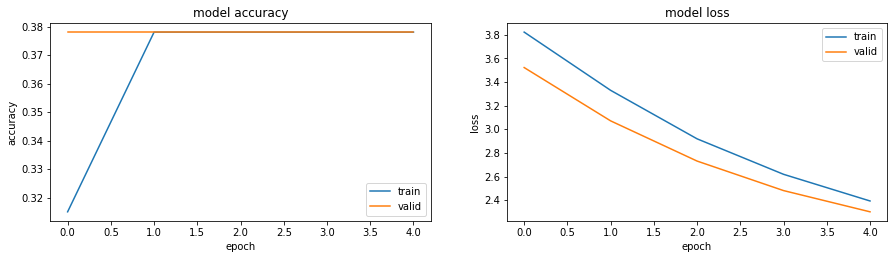

In [14]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()